In [1]:
%matplotlib inline 
 
# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()

import importlib
from libs import params, preps, feats, plots, models_core, models_custom
importlib.reload(params)
importlib.reload(preps)
importlib.reload(feats)
importlib.reload(plots)
importlib.reload(models_core)
importlib.reload(models_custom)

<module 'libs.models_custom' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_custom.py'>

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy  as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
import os
from typing import Sequence, List, Tuple, Optional, Union
from pathlib import Path
import time
import io
import contextlib

import torch
import torch.nn as nn
from torch.nn import MSELoss, Dropout
import torch.nn.functional as Funct
from torch_lr_finder import LRFinder
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, ReduceLROnPlateau, OneCycleLR
from torch.amp import GradScaler

from tqdm import tqdm
import h5py

from copy import deepcopy
from typing import Callable, List, Dict, Tuple, Optional
from pprint import pprint
from PIL import Image

import shap
from captum.attr import IntegratedGradients

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.preprocessing import StandardScaler

from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

from IPython.display import clear_output, display


In [4]:
df_all_features = pd.read_csv(params.feat_all_csv, index_col=0, parse_dates=True) 
# df_all_features = df_all_features[df_all_features.index.year >= params.init_df_year] ##################
df_all_features

,volume,trade_count,ret,log_ret,sma_pct_5,sma_pct_9,sma_pct_21,sma_pct_50,sma_pct_100,sma_pct_200,roc_5,roc_10,roc_21,body_pct,upper_shad,lower_shad,range_pct,rsi_6,rsi_14,rsi_21,atr_pct_7,atr_pct_14,atr_pct_28,plus_di_7,minus_di_7,adx_7,plus_di_14,minus_di_14,adx_14,plus_di_28,minus_di_28,adx_28,bb_w_20_2p0,bb_w_20_3p0,bb_w_50_2p0,vol_spike_7,vol_spike_14,vol_spike_28,dist_high_200,dist_low_200,obv_diff_7,obv_pct_7,obv_diff_21,obv_pct_21,ret_std_21,ret_std_63,stoch_k_14_3_3,stoch_d_14_3_3,stoch_k_9_3_3,stoch_d_9_3_3,cci_14,cci_20,mfi_14,mfi_20,cmf_14,cmf_20,donch_w_20,donch_w_55,kc_w_20_20_1.5,kc_w_20_20_2.0,close_raw,atr_14_raw,adx_14_raw,rsi_6_raw,vwap_ohlc_close_session_raw,vwap_RZ,sma_5_RZ,sma_9_RZ,sma_21_RZ,sma_50_RZ,sma_100_RZ,sma_200_RZ,ema_3_RZ,ema_5_RZ,ema_8_RZ,ema_9_RZ,ema_13_RZ,ema_21_RZ,ema_50_RZ,macd_line_6_13_5_RZ,macd_signal_6_13_5_RZ,macd_diff_6_13_5_RZ,macd_line_12_26_9_RZ,macd_signal_12_26_9_RZ,macd_diff_12_26_9_RZ,atr_7_RZ,atr_14_RZ,atr_28_RZ,rolling_max_close_200_RZ,rolling_min_close_200_RZ,roll_vwap_20_RZ,roll_vwap_50_RZ,slope_close_20_RZ,slope_close_50_RZ,psar_RZ,vwap_ohlc_close_session_RZ,time_minute,time_hour,time_dow,time_month,time_day_of_year,time_week_of_year,time_in_sess,time_premark,time_afthour
2015-12-31 23:00:00,0.000396,0.000000,NaN,NaN,0.501100,0.501252,0.503744,0.506768,0.510859,0.515380,NaN,NaN,NaN,0.502374,0.0000,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.499818,0.498705,0.500000,0.500000,NaN,NaN,NaN,NaN,0.000000,0.000000,26.3575,0.000000,0.000000,NaN,26.357500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.895833,0.895833,0.928571,0.416667,0.497260,0.500000,0.0,0.0,1.0
2015-12-31 23:01:00,0.001586,0.001020,0.419100,0.419525,0.463940,0.475557,0.487773,0.496842,0.503946,0.510473,NaN,NaN,NaN,0.502374,0.0000,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.499818,0.498705,0.500000,0.500000,NaN,NaN,NaN,NaN,0.000000,0.000000,26.3500,0.000000,0.000000,NaN,26.351930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.896528,0.895833,0.928571,0.416667,0.497260,0.500000,0.0,0.0,1.0
2015-12-31 23:02:00,0.001202,0.000765,0.500539,0.500976,0.476326,0.484121,0.493096,0.500150,0.506250,0.512109,NaN,NaN,NaN,0.502374,0.0000,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.499818,0.498705,0.500000,0.500000,NaN,NaN,NaN,NaN,0.000000,0.000000,26.3500,0.000000,0.000000,NaN,26.351217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.897222,0.895833,0.928571,0.416667,0.497260,0.500000,0.0,0.0,1.0
2015-12-31 23:03:00,0.000817,0.000510,0.500539,0.500976,0.482519,0.488403,0.495758,0.501804,0.507402,0.512927,NaN,NaN,NaN,0.502374,0.0000,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.499818,0.498705,0.500000,0.500000,NaN,NaN,NaN,NaN,0.000000,0.000000,26.3500,0.000000,0.000000,NaN,26.350958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.897917,0.895833,0.928571,0.416667,0.497260,0.500000,0.0,0.0,1.0
2015-12-31 23:04:00,0.000432,0.0

In [5]:
# importlib.reload(preps) #######
df_allfeats_sign = preps.build_signal_per_day( 
    df              = df_all_features, 
    min_prof_thr    = params.min_prof_thr_tick,
    max_down_prop   = params.max_down_prop_tick,
    gain_tightfact  = params.gain_tightfact_tick,
    tau_time        = params.tau_time_tick,
    tau_dur         = params.tau_dur_tick,
    thresh_mode     = params.thresh_mode_tick,
    thresh_window   = params.thresh_window_tick,
    col_close       = 'close_raw'
)
df_allfeats_sign

,volume,trade_count,ret,log_ret,sma_pct_5,sma_pct_9,sma_pct_21,sma_pct_50,sma_pct_100,sma_pct_200,roc_5,roc_10,roc_21,body_pct,upper_shad,lower_shad,range_pct,rsi_6,rsi_14,rsi_21,atr_pct_7,atr_pct_14,atr_pct_28,plus_di_7,minus_di_7,adx_7,plus_di_14,minus_di_14,adx_14,plus_di_28,minus_di_28,adx_28,bb_w_20_2p0,bb_w_20_3p0,bb_w_50_2p0,vol_spike_7,vol_spike_14,vol_spike_28,dist_high_200,dist_low_200,obv_diff_7,obv_pct_7,obv_diff_21,obv_pct_21,ret_std_21,ret_std_63,stoch_k_14_3_3,stoch_d_14_3_3,stoch_k_9_3_3,stoch_d_9_3_3,cci_14,cci_20,mfi_14,mfi_20,cmf_14,cmf_20,donch_w_20,donch_w_55,kc_w_20_20_1.5,kc_w_20_20_2.0,close_raw,atr_14_raw,adx_14_raw,rsi_6_raw,vwap_ohlc_close_session_raw,vwap_RZ,sma_5_RZ,sma_9_RZ,sma_21_RZ,sma_50_RZ,sma_100_RZ,sma_200_RZ,ema_3_RZ,ema_5_RZ,ema_8_RZ,ema_9_RZ,ema_13_RZ,ema_21_RZ,ema_50_RZ,macd_line_6_13_5_RZ,macd_signal_6_13_5_RZ,macd_diff_6_13_5_RZ,macd_line_12_26_9_RZ,macd_signal_12_26_9_RZ,macd_diff_12_26_9_RZ,atr_7_RZ,atr_14_RZ,atr_28_RZ,rolling_max_close_200_RZ,rolling_min_close_200_RZ,roll_vwap_20_RZ,roll_vwap_50_RZ,slope_close_20_RZ,slope_close_50_RZ,psar_RZ,vwap_ohlc_close_session_RZ,time_minute,time_hour,time_dow,time_month,time_day_of_year,time_week_of_year,time_in_sess,time_premark,time_afthour,signal_raw,swing_dir,swing_gain_pct,last_buy,last_sell,signal_thresh,gap_to_thresh
2015-12-31 23:00:00,0.000396,0.000000,NaN,NaN,0.501100,0.501252,0.503744,0.506768,0.510859,0.515380,NaN,NaN,NaN,0.502374,0.0000,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.499818,0.498705,0.500000,0.500000,NaN,NaN,NaN,NaN,0.000000,0.000000,26.3575,0.000000,0.000000,NaN,26.357500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.895833,0.895833,0.928571,0.416667,0.497260,0.500000,0.0,0.0,1.0,0.000095,1,0.056926,2015-12-31 23:54:00,2015-12-31 23:57:00,0.002243,-0.002148
2015-12-31 23:01:00,0.001586,0.001020,0.419100,0.419525,0.463940,0.475557,0.487773,0.496842,0.503946,0.510473,NaN,NaN,NaN,0.502374,0.0000,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.499818,0.498705,0.500000,0.500000,NaN,NaN,NaN,NaN,0.000000,0.000000,26.3500,0.000000,0.000000,NaN,26.351930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.896528,0.895833,0.928571,0.416667,0.497260,0.500000,0.0,0.0,1.0,0.000214,1,0.056926,2015-12-31 23:54:00,2015-12-31 23:57:00,0.002243,-0.002028
2015-12-31 23:02:00,0.001202,0.000765,0.500539,0.500976,0.476326,0.484121,0.493096,0.500150,0.506250,0.512109,NaN,NaN,NaN,0.502374,0.0000,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.499818,0.498705,0.500000,0.500000,NaN,NaN,NaN,NaN,0.000000,0.000000,26.3500,0.000000,0.000000,NaN,26.351217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.897222,0.895833,0.928571,0.416667,0.497260,0.500000,0.0,0.0,1.0,0.000243,1,0.056926,2015-12-31 23:54:00,2015-12-31 23:57:00,0.002243,-0.002000
2015-12-31 23:03:00,0.000817,0.000510,0.500539,0.500976,0.482519,0.488403,0.495758,0.501804,0.507402,0.512927,NaN,NaN,NaN,0.502374,0.0000,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.499818,0.4

In [7]:
# Separate feature matrix X and target vector y
exclude = {f"{col}_raw" for col in params.strategy_cols_tick} \
          | set(params.signals_cols_tick) \
          | {'swing_dir', 'swing_gain_pct', 'last_buy', 'last_sell', 'gap_to_thresh'}

all_features = [c for c in df_allfeats_sign.columns if c not in exclude]
X_all        = df_allfeats_sign[all_features]
y            = df_allfeats_sign['signal_raw']

print(all_features)

['volume', 'trade_count', 'ret', 'log_ret', 'sma_pct_5', 'sma_pct_9', 'sma_pct_21', 'sma_pct_50', 'sma_pct_100', 'sma_pct_200', 'roc_5', 'roc_10', 'roc_21', 'body_pct', 'upper_shad', 'lower_shad', 'range_pct', 'rsi_6', 'rsi_14', 'rsi_21', 'atr_pct_7', 'atr_pct_14', 'atr_pct_28', 'plus_di_7', 'minus_di_7', 'adx_7', 'plus_di_14', 'minus_di_14', 'adx_14', 'plus_di_28', 'minus_di_28', 'adx_28', 'bb_w_20_2p0', 'bb_w_20_3p0', 'bb_w_50_2p0', 'vol_spike_7', 'vol_spike_14', 'vol_spike_28', 'dist_high_200', 'dist_low_200', 'obv_diff_7', 'obv_pct_7', 'obv_diff_21', 'obv_pct_21', 'ret_std_21', 'ret_std_63', 'stoch_k_14_3_3', 'stoch_d_14_3_3', 'stoch_k_9_3_3', 'stoch_d_9_3_3', 'cci_14', 'cci_20', 'mfi_14', 'mfi_20', 'cmf_14', 'cmf_20', 'donch_w_20', 'donch_w_55', 'kc_w_20_20_1.5', 'kc_w_20_20_2.0', 'vwap_RZ', 'sma_5_RZ', 'sma_9_RZ', 'sma_21_RZ', 'sma_50_RZ', 'sma_100_RZ', 'sma_200_RZ', 'ema_3_RZ', 'ema_5_RZ', 'ema_8_RZ', 'ema_9_RZ', 'ema_13_RZ', 'ema_21_RZ', 'ema_50_RZ', 'macd_line_6_13_5_RZ', 'mac

Pruning features:   0%|          | 0/100 [00:00<?, ?it/s]


Dropped low-variance features (n=0):
  None

Dropped by correlation (n=3), mapping Dropped <-- Kept (corr):
  Dropped: log_ret  (corr=1.0000)  <-- Kept: ret
  Dropped: bb_w_20_3p0  (corr=1.0000)  <-- Kept: bb_w_20_2p0
  Dropped: kc_w_20_20_1.5  (corr=1.0000)  <-- Kept: kc_w_20_20_2.0

Kept after std filter (n=100).
Kept after correlation pruning (n=97).

Final kept features:
  ['volume', 'trade_count', 'ret', 'sma_pct_5', 'sma_pct_9', 'sma_pct_21', 'sma_pct_50', 'sma_pct_100', 'sma_pct_200', 'roc_5', 'roc_10', 'roc_21', 'body_pct', 'upper_shad', 'lower_shad', 'range_pct', 'rsi_6', 'rsi_14', 'rsi_21', 'atr_pct_7', 'atr_pct_14', 'atr_pct_28', 'plus_di_7', 'minus_di_7', 'adx_7', 'plus_di_14', 'minus_di_14', 'adx_14', 'plus_di_28', 'minus_di_28', 'adx_28', 'bb_w_20_2p0', 'bb_w_50_2p0', 'vol_spike_7', 'vol_spike_14', 'vol_spike_28', 'dist_high_200', 'dist_low_200', 'obv_diff_7', 'obv_pct_7', 'obv_diff_21', 'obv_pct_21', 'ret_std_21', 'ret_std_63', 'stoch_k_14_3_3', 'stoch_d_14_3_3', 'stoch

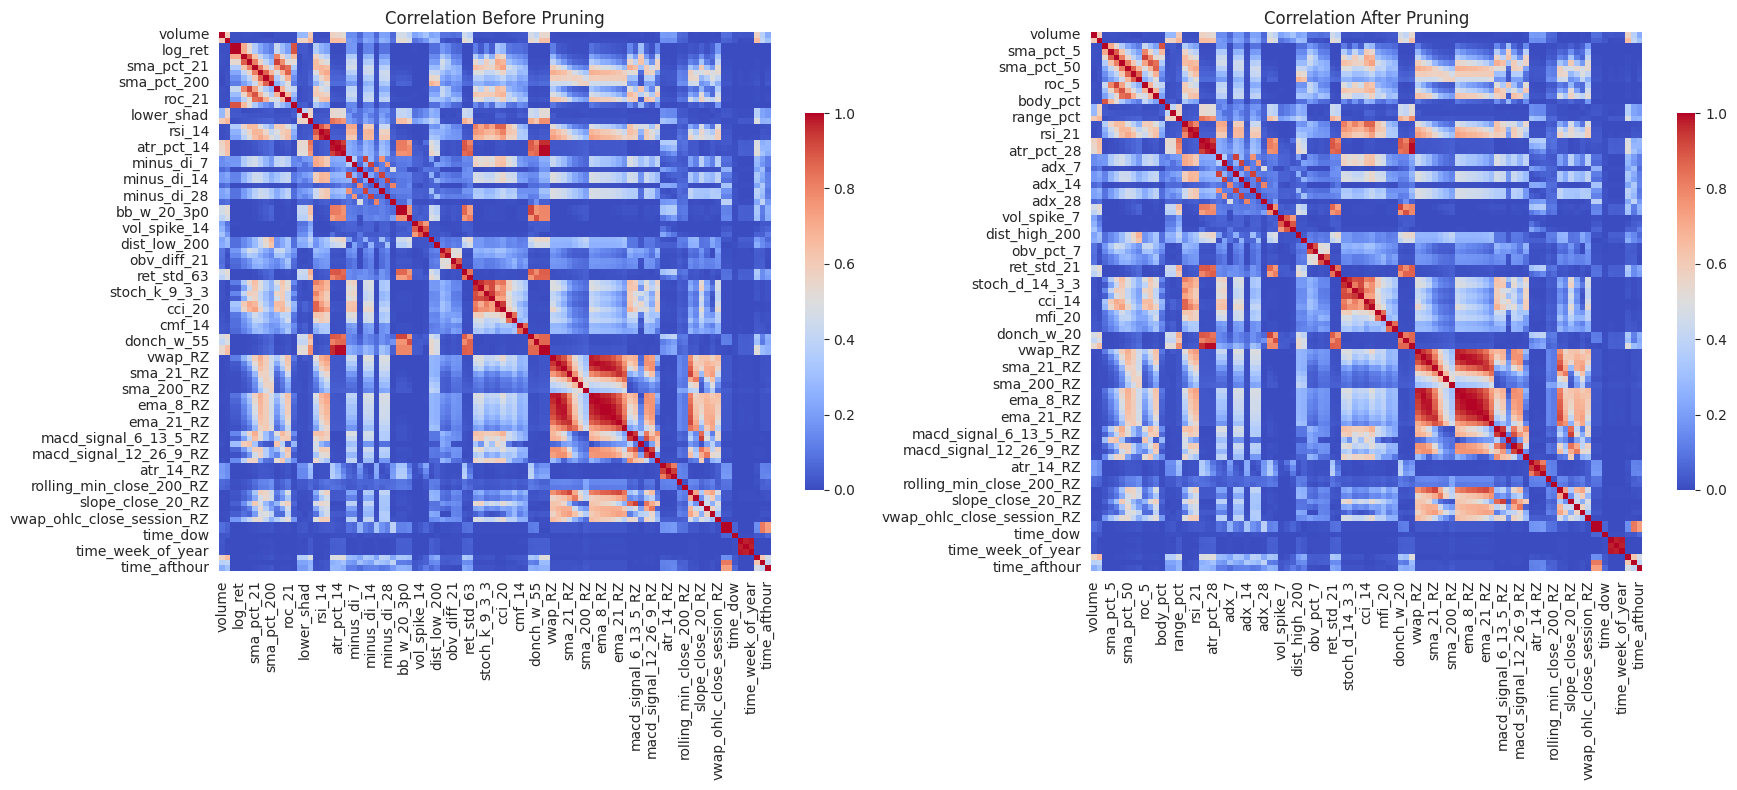

In [8]:
# importlib.reload(feats)
kept_final_feats, pruned_feats, corr_full, corr_pruned = feats.prune_features_by_variance_and_correlation(
    X_all=X_all,
    y=y,
    min_std=params.feats_min_std,
    max_corr=params.feats_max_corr,
)

# show heatmaps
plots.plot_correlation_before_after(corr_full, corr_pruned)

In [10]:
# build final feature DataFrame with signal and all features kept
cols = kept_final_feats + params.signals_cols_tick + [f"{col}_raw" for col in params.strategy_cols_tick]
df_sign_allfeats = df_allfeats_sign[list(dict.fromkeys(cols)) ] # remove duplicates, keep order

params.to_csv_with_progress(df_sign_allfeats, params.sign_featall_csv)
df_sign_allfeats

Saving CSV: 100%|██████████| 2355804/2355804 [06:26<00:00, 6087.85rows/s, size=4.0GB] 


,volume,trade_count,ret,sma_pct_5,sma_pct_9,sma_pct_21,sma_pct_50,sma_pct_100,sma_pct_200,roc_5,roc_10,roc_21,body_pct,upper_shad,lower_shad,range_pct,rsi_6,rsi_14,rsi_21,atr_pct_7,atr_pct_14,atr_pct_28,plus_di_7,minus_di_7,adx_7,plus_di_14,minus_di_14,adx_14,plus_di_28,minus_di_28,adx_28,bb_w_20_2p0,bb_w_50_2p0,vol_spike_7,vol_spike_14,vol_spike_28,dist_high_200,dist_low_200,obv_diff_7,obv_pct_7,obv_diff_21,obv_pct_21,ret_std_21,ret_std_63,stoch_k_14_3_3,stoch_d_14_3_3,stoch_k_9_3_3,stoch_d_9_3_3,cci_14,cci_20,mfi_14,mfi_20,cmf_14,cmf_20,donch_w_20,donch_w_55,kc_w_20_20_2.0,vwap_RZ,sma_5_RZ,sma_9_RZ,sma_21_RZ,sma_50_RZ,sma_100_RZ,sma_200_RZ,ema_3_RZ,ema_5_RZ,ema_8_RZ,ema_9_RZ,ema_13_RZ,ema_21_RZ,ema_50_RZ,macd_line_6_13_5_RZ,macd_signal_6_13_5_RZ,macd_diff_6_13_5_RZ,macd_line_12_26_9_RZ,macd_signal_12_26_9_RZ,macd_diff_12_26_9_RZ,atr_7_RZ,atr_14_RZ,atr_28_RZ,rolling_max_close_200_RZ,rolling_min_close_200_RZ,roll_vwap_20_RZ,roll_vwap_50_RZ,slope_close_20_RZ,slope_close_50_RZ,psar_RZ,vwap_ohlc_close_session_RZ,time_minute,time_hour,time_dow,time_month,time_day_of_year,time_week_of_year,time_in_sess,time_premark,time_afthour,close_raw,signal_raw,signal_thresh,atr_14_raw,adx_14_raw,rsi_6_raw,vwap_ohlc_close_session_raw
2015-12-31 23:00:00,0.000396,0.000000,NaN,0.501100,0.501252,0.503744,0.506768,0.510859,0.515380,NaN,NaN,NaN,0.502374,0.0000,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.499818,0.498705,0.500000,0.500000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.895833,0.895833,0.928571,0.416667,0.497260,0.500000,0.0,0.0,1.0,26.3575,0.000095,0.002243,0.000000,0.000000,NaN,26.357500
2015-12-31 23:01:00,0.001586,0.001020,0.419100,0.463940,0.475557,0.487773,0.496842,0.503946,0.510473,NaN,NaN,NaN,0.502374,0.0000,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.499818,0.498705,0.500000,0.500000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.896528,0.895833,0.928571,0.416667,0.497260,0.500000,0.0,0.0,1.0,26.3500,0.000214,0.002243,0.000000,0.000000,NaN,26.351930
2015-12-31 23:02:00,0.001202,0.000765,0.500539,0.476326,0.484121,0.493096,0.500150,0.506250,0.512109,NaN,NaN,NaN,0.502374,0.0000,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.499818,0.498705,0.500000,0.500000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.897222,0.895833,0.928571,0.416667,0.497260,0.500000,0.0,0.0,1.0,26.3500,0.000243,0.002243,0.000000,0.000000,NaN,26.351217
2015-12-31 23:03:00,0.000817,0.000510,0.500539,0.482519,0.488403,0.495758,0.501804,0.507402,0.512927,NaN,NaN,NaN,0.502374,0.0000,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.499818,0.498705,0.500000,0.500000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.897917,0.895833,0.928571,0.416667,0.497260,0.500000,0.0,0.0,1.0,26.3500,0.000275,0.002243,0.000000,0.000000,NaN,26.350958
2015-12-31 23:04:00,0.000432,0.000255,0.500539,0.4862

In [ ]:
light_look_back = 30 # for a less expensive training (given that we are already using all features)

# importlib.reload(models_core) ########
train_loader, val_loader, test_loader, end_times_tr, end_times_val, end_times_te = models_core.model_core_pipeline(
    df              = df_sign_allfeats,
    train_batch     = params.hparams["TRAIN_BATCH"],
    train_workers   = params.hparams["TRAIN_WORKERS"],
    prefetch_factor = params.hparams["TRAIN_PREFETCH_FACTOR"],
    look_back       = light_look_back, # params.hparams["LOOK_BACK"],
    features_cols   = kept_final_feats,
)

del df_all_features, df_allfeats_sign, df_sign_allfeats, end_times_tr, end_times_val, end_times_te
gc.collect()

In [ ]:
# Save test_loader X_windows and y_windows to be reused for feature importance
importlib.reload(feats)
X_path, y_path, meta_path = feats.extract_and_save_windows(test_loader, out_dir=params.models_folder, features=kept_final_feats)
X_path, y_path, meta_path

In [ ]:
#################### MODEL TRAINING #####################

model = models_custom.ModelClass(
    n_feats             = len(kept_final_feats),
    short_units         = params.hparams["SHORT_UNITS"],
    long_units          = params.hparams["LONG_UNITS"],
    transformer_d_model = params.hparams["TRANSFORMER_D_MODEL"],
    transformer_layers  = params.hparams["TRANSFORMER_LAYERS"],
    dropout_short       = params.hparams["DROPOUT_SHORT"],
    dropout_long        = params.hparams["DROPOUT_LONG"],
    dropout_trans       = params.hparams["DROPOUT_TRANS"],
    pred_hidden         = params.hparams["PRED_HIDDEN"],
    look_back           = light_look_back, # params.hparams["LOOK_BACK"],

    # Gating flags
    use_conv            = params.hparams["USE_CONV"],
    use_tcn             = params.hparams["USE_TCN"],
    use_short_lstm      = params.hparams["USE_SHORT_LSTM"],
    use_transformer     = params.hparams["USE_TRANSFORMER"],
    use_long_lstm       = params.hparams["USE_LONG_LSTM"],
    use_delta           = params.hparams["USE_DELTA"],
    flatten_mode        = params.hparams["FLATTEN_MODE"]
)

model.feature_names = kept_final_feats # for logging
model.to(params.device)  
    
optimizer = AdamW(
  model.parameters(),
  lr           = params.hparams["ONECYCLE_MAX_LR"],
  weight_decay = params.hparams["WEIGHT_DECAY"]
)

batches_per_epoch = len(train_loader)
total_steps = batches_per_epoch * params.hparams["MAX_EPOCHS"]

scheduler = OneCycleLR(
  optimizer,
  max_lr           = params.hparams["ONECYCLE_MAX_LR"],
  total_steps      = total_steps,
  pct_start        = params.hparams["ONECYCLE_PCT_START"],
  div_factor       = params.hparams["ONECYCLE_DIV_FACTOR"],
  final_div_factor = params.hparams["ONECYCLE_FINAL_DIV"],
  anneal_strategy  = params.hparams["ONECYCLE_STRATEGY"],
)
optimizer.scheduler = scheduler # necessary to log sched_field

if getattr(scheduler, "total_steps", None) != total_steps:
    raise RuntimeError(f"Scheduler total_steps mismatch: scheduler={getattr(scheduler,'total_steps',None)} expected={total_steps}")

n_days = len(train_loader.dataset)
print(f"Training sees {n_days} unique trading days per epoch.\n")

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model parameters: total={total_params:,}, trainable={trainable_params:,}\n")
print('Using HyperParameters:\n', params.hparams)
print('\ntorch.cuda.is_available', torch.cuda.is_available())

# -----------------------------------------------------------------------------
# Run the custom stateful training loop
# -----------------------------------------------------------------------------
best_val_rmse  = models_custom.model_training_loop(
    model               = model,
    optimizer           = optimizer,
    scheduler           = scheduler,
    scaler              = GradScaler(),
    train_loader        = train_loader,
    val_loader          = val_loader,
    all_features        = True
)

# retrieve model just trained (keep exactly 5 decimals)
fname = f"{params.ticker}_{best_val_rmse:.5f}_all.pth"
chk = Path(params.models_folder) / fname

# load checkpoint and recreate model from stored hparams
ckpt = torch.load(chk, map_location="cpu", weights_only=False)

# load weights, move to device, set eval
model.load_state_dict(ckpt["model_state_dict"])
model.eval()

print("Loaded checkpoint:", chk)